In [1]:
# install.packages("plm")
# install.packages("stargazer")

In [2]:
library(tidyverse)
library(ggplot2)
library(nanoparquet)
library(arrow)
library(sf)
library(plm)
library(stargazer)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.3.0
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.1.0     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'nanoparquet' was built under R version 4.5.2"

Attaching package: 'arrow'


The following objects are masked from 'package:nanoparquet':

    read_parquet, write_parquet


The following object is masked from 'package:lubridate':

    duration


The following object is masked from 'package:utils':

    timestamp


Warning message:
"package 'sf' was built under R version 4.5.2"
Linking to GEOS 3.13.1, GDAL 3.11.4, PROJ 9.7.0; sf_use_s2() is TRUE



In [3]:
toi <- c("rape_total", "robbery_total", "burglary_total", "theft_total", "assault_total", "all_crimes")

crime_df_al <- open_dataset("../data/us_crime_data_2012_2024.parquet") |>
 filter(state == "alabama") |>
 filter(year < 2021 & offense_type %in% toi)|>
 collect() |>
 glimpse()

Rows: 314,496
Columns: 20
$ file_id                     <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1~
$ geoid                       <chr> "0199073", "0199073", "0199073", "0199073"~
$ state                       <chr> "alabama", "alabama", "alabama", "alabama"~
$ state_abb                   <chr> "AL", "AL", "AL", "AL", "AL", "AL", "AL", ~
$ address_city                <chr> "birmingham", "birmingham", "birmingham", ~
$ census_name                 <chr> "jefferson county", "jefferson county", "j~
$ year                        <dbl> 2012, 2012, 2012, 2012, 2012, 2012, 2012, ~
$ month                       <chr> "january", "january", "january", "january"~
$ date                        <date> 2012-01-01, 2012-01-01, 2012-01-01, 2012-~
$ population                  <dbl> 146028, 146028, 146028, 146028, 146028, 14~
$ population_group            <chr> "msa-county 100,000+", "msa-county 100,000~
$ core_city_indication        <chr> "not core city of msa", "not core city of ~
$ officers_kil

In [4]:
ntl_al <- nanoparquet::read_parquet("../data/ntl_vnp46a3_all_places_2012_2024.parquet") |>
    filter(STATE_NAME == "Alabama")|>
    select(GEOID, month, ntl_mean) |>
    mutate(date = month)|>
    select(-month) |>
    # Put colnames in lower case
    rename_all(tolower) |>
    glimpse()

Rows: 87,912
Columns: 3
$ geoid    <chr> "0132704", "0145472", "0153784", "0178204", "0102836", "01620~
$ ntl_mean <dbl> 8.5810881, 12.8815603, 2.5939567, 12.8558397, 5.8091664, 1.87~
$ date     <date> 2012-01-01, 2012-01-01, 2012-01-01, 2012-01-01, 2012-01-01, ~


In [5]:
# Read in geospatial data for Alabama places
places_sf <- st_read("../data/us_places.geojson")|>
    filter(STATE_NAME == "Alabama")|>
    select(GEOID, geometry)|>
    rename_all(tolower)

Reading layer `us_places' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\ntl_crime\data\us_places.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32041 features and 12 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -176.6967 ymin: 19.01848 xmax: 174.1553 ymax: 71.33971
Geodetic CRS:  WGS 84


In [6]:
# Load the moon phases data
moon_al <- read_csv("../data/usno_moon_monthly_AL_CST_2012_2024.csv")|>
    mutate(date = as.Date(paste(year_month, "01", sep = "-"))) |>
    select(date, moon_fracillum_mean)|>
    glimpse()

Rows: 156 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): year_month, state
dbl (6): year, month, moon_fracillum_mean, n_days, tz_hours, tz_sign

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 156
Columns: 2
$ date                <date> 2012-01-01, 2012-02-01, 2012-03-01, 2012-04-01, 2~
$ moon_fracillum_mean <dbl> 0.504516, 0.489310, 0.479355, 0.471000, 0.480323, ~


In [7]:
# Merge the ntl data with the geospatial data
ntl_al_sf <- ntl_al |>
    left_join(places_sf, by = "geoid") |>
    st_as_sf() |>
    glimpse()

Rows: 87,912
Columns: 4
$ geoid    <chr> "0132704", "0145472", "0153784", "0178204", "0102836", "01620~
$ ntl_mean <dbl> 8.5810881, 12.8815603, 2.5939567, 12.8558397, 5.8091664, 1.87~
$ date     <date> 2012-01-01, 2012-01-01, 2012-01-01, 2012-01-01, 2012-01-01, ~
$ geometry <MULTIPOLYGON [°]> MULTIPOLYGON (((-87.60417 3..., MULTIPOLYGON (((~


In [8]:
# Join ntl data into crime data
crime_ntl_al <- crime_df_al |>
    left_join(ntl_al, by = c("geoid", "date")) |>
    left_join(moon_al, by = "date") |>
    # Using the whole 2012 ntl mean as a baseline, calculate ntl growth
    # group_by(geoid) |>
    # mutate(ntl_baseline = mean(ntl_mean[year == 2012], na.rm = TRUE),
    #        ntl_growth = ntl_mean - ntl_baseline) |>
    # filter( !is.na(ntl_growth)) |>
    filter(!is.na(moon_fracillum_mean)) |>
    # Remove 2012 to focus on post-baseline period
    filter(year < 2021) |>
    # ungroup() |>
    mutate(l_crime_count = log1p(actual_count),
        l_ntl_mean = log1p(ntl_mean))|>
    mutate(unit = interaction(geoid, offense_type, drop = TRUE))|>
    glimpse()

Rows: 314,496
Columns: 25
$ file_id                     <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1~
$ geoid                       <chr> "0199073", "0199073", "0199073", "0199073"~
$ state                       <chr> "alabama", "alabama", "alabama", "alabama"~
$ state_abb                   <chr> "AL", "AL", "AL", "AL", "AL", "AL", "AL", ~
$ address_city                <chr> "birmingham", "birmingham", "birmingham", ~
$ census_name                 <chr> "jefferson county", "jefferson county", "j~
$ year                        <dbl> 2012, 2012, 2012, 2012, 2012, 2012, 2012, ~
$ month                       <chr> "january", "january", "january", "january"~
$ date                        <date> 2012-01-01, 2012-01-01, 2012-01-01, 2012-~
$ population                  <dbl> 146028, 146028, 146028, 146028, 146028, 14~
$ population_group            <chr> "msa-county 100,000+", "msa-county 100,000~
$ core_city_indication        <chr> "not core city of msa", "not core city of ~
$ officers_kil

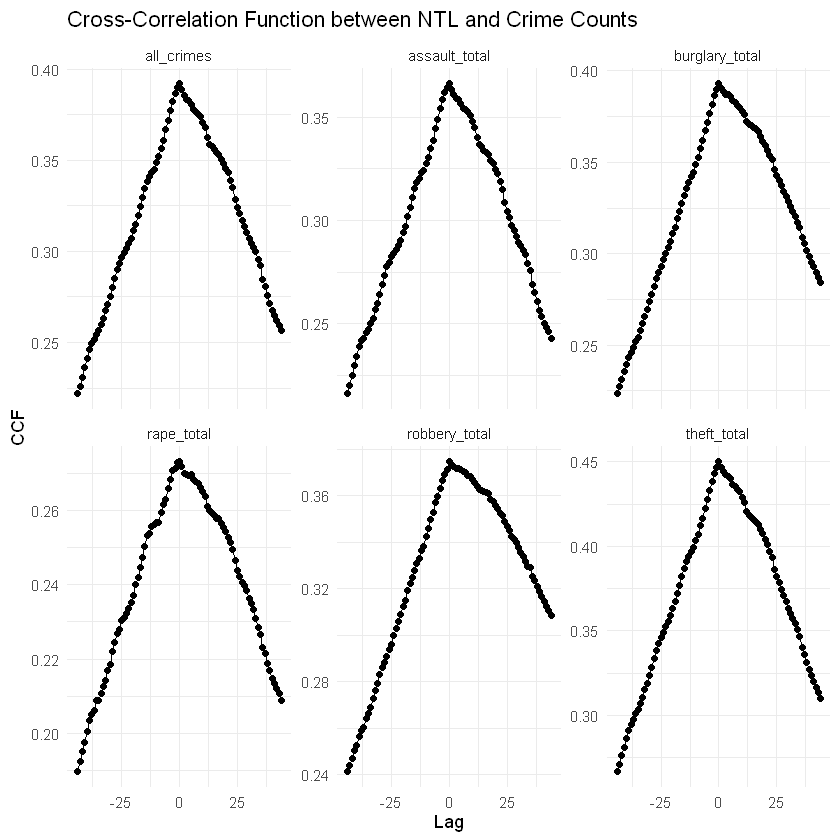

In [9]:
# Calculate the cross autocorrelation function between ntl and crime for each type of crime
ccf_results <- list()

for (crime in toi) {
    df_subset <- crime_ntl_al |>
        filter(offense_type == crime) |>
        arrange(geoid, date)

    # Use na.action = na.pass to handle NAs in the time series
    ccf_values <- ccf(df_subset$l_ntl_mean, df_subset$l_crime_count, plot = FALSE, na.action = na.pass)

    ccf_results[[crime]] <- data.frame(
        lag = as.numeric(ccf_values$lag),
        ccf = as.numeric(ccf_values$acf),
        offense_type = crime
    )
}

# Combine results into a single data frame
ccf_df <- bind_rows(ccf_results)

# Plot the CCF results
ggplot(ccf_df, aes(x = lag, y = ccf)) +
    geom_line() +
    geom_point() +
    facet_wrap(~ offense_type, scales = "free_y") +
    labs(title = "Cross-Correlation Function between NTL and Crime Counts",
         x = "Lag",
         y = "CCF") +
    theme_minimal()

In [10]:
# Fit the baseline fixed effects model
tw_base <- plm(l_crime_count ~ l_ntl_mean:factor(offense_type) + moon_fracillum_mean 
                + factor(month) + factor(population_group),
                data = crime_ntl_al,
                index = c("unit", "date"),
                model = "within",
                effect = "twoways")

# Print the summary of the model
summary(tw_base)

Warning message in pdata.frame(data, index = index, ...):
"duplicate couples (id-time) in resulting pdata.frame
 to find out which, use, e.g., table(index(your_pdataframe), useNA = "ifany")"
Warning message in pdata.frame(data, index = index, ...):
"at least one NA in at least one index dimension in resulting pdata.frame
 to find out which, use, e.g., table(index(your_pdataframe), useNA = "ifany")
"


Twoways effects Within Model

Call:
plm(formula = l_crime_count ~ l_ntl_mean:factor(offense_type) + 
    moon_fracillum_mean + factor(month) + factor(population_group), 
    data = crime_ntl_al, effect = "twoways", model = "within", 
    index = c("unit", "date"))

Unbalanced Panel: n = 2076, T = 48-1620, N = 251928

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-5.624135 -0.215221 -0.063315  0.360630  5.368422 

Coefficients:
                                                      Estimate Std. Error
factor(population_group)city 100,000 thru 249,999    1.4110828  0.0205614
factor(population_group)city 2,500 thru 9,999       -0.7961378  0.0187804
factor(population_group)city 25,000 thru 49,999      0.4951526  0.0214367
factor(population_group)city 250,000 thru 499,999    1.5894853  0.0452797
factor(population_group)city 50,000 thru 99,999      1.1747629  0.0219426
factor(population_group)city under 2,500            -1.8834351  0.0135085
factor(population_group)msa-county 

In [11]:
library(lmtest)
library(sandwich)

# Calculate robust standard errors clustered at the unit level
coeftest(tw_base, vcov = vcovHC(tw_base, type="HC1", cluster="group"))

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric





t test of coefficients:

                                                      Estimate Std. Error
factor(population_group)city 100,000 thru 249,999    1.4110828  0.2790232
factor(population_group)city 2,500 thru 9,999       -0.7961378  0.2203238
factor(population_group)city 25,000 thru 49,999      0.4951526  0.2513183
factor(population_group)city 250,000 thru 499,999    1.5894853  0.3834245
factor(population_group)city 50,000 thru 99,999      1.1747629  0.3521933
factor(population_group)city under 2,500            -1.8834351  0.1879587
factor(population_group)msa-county under 10,000     -1.9349827  0.2018238
factor(population_group)msa state police            -1.9300609  0.2013703
factor(population_group)non-msa county under 10,000 -1.9464555  0.2033270
factor(population_group)possessions                 -2.3190743  0.1963171
l_ntl_mean:factor(offense_type)all_crimes            0.2844124  0.1105519
l_ntl_mean:factor(offense_type)assault_total         0.0057398  0.0864179
l_ntl_mean:f

In [12]:
# create a stargazer table
stargazer(tw_base,
          type = "text",
          title = "Fixed Effects Model Results: Crime Count in Alabama Places (2013-2020)",
          dep.var.labels = c("Log(Crime Count + 1)"))


Fixed Effects Model Results: Crime Count in Alabama Places (2013-2020)
                                                         Dependent variable:      
                                                    ------------------------------
                                                         Log(Crime Count + 1)     
----------------------------------------------------------------------------------
factor(population_group)city 100,000 thru 249,999              1.411***           
                                                               (0.021)            
                                                                                  
factor(population_group)city 2,500 thru 9,999                 -0.796***           
                                                               (0.019)            
                                                                                  
factor(population_group)city 25,000 thru 49,999                0.495***           
               